### Importing all the libraries

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import random
import pickle
import pandas as pd
import cv2

In [78]:
np.random.seed(0)

### Loading the data as train, test & valadition.

In [79]:
with open('Datasets/train.p', 'rb') as f:
    train_data = pickle.load(f)
with open('Datasets/valid.p', 'rb') as f:
    val_data = pickle.load(f)
# TODO: Load test data
with open('Datasets/test.p', 'rb') as f:
    test_data = pickle.load(f)
    
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']
    
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
 

(34799, 32, 32, 3)
(12630, 32, 32, 3)
(4410, 32, 32, 3)


### This step is just to make sure that I can come to know about any errors easily. One can skip this step if wanted

In [80]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels."
assert(X_train.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels."
assert(X_val.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels."
assert(X_test.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."

### Visualising the data

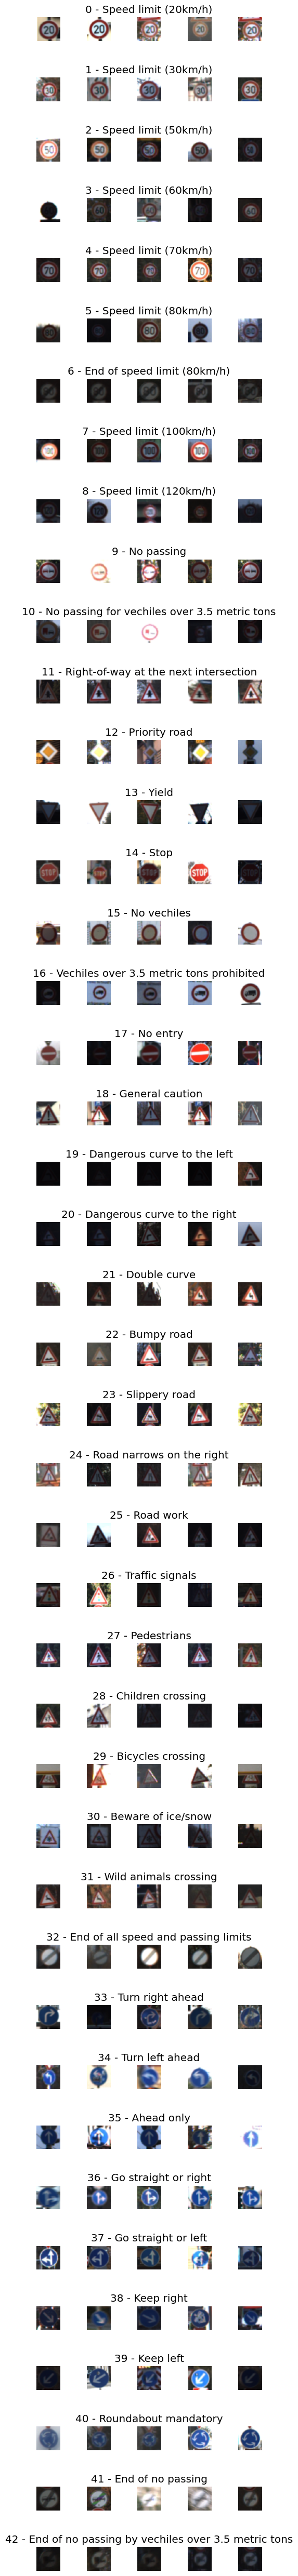

In [81]:
data = pd.read_csv('Datasets/signnames.csv')
num_of_samples=[]
 
cols = 5
num_classes = 43
 
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()
 
for i in range(cols):
    for j, row in data.iterrows():
      x_selected = X_train[y_train == j]
      axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
      axs[j][i].axis("off")
      if i == 2:
        axs[j][i].set_title(str(j) + " - " + row["SignName"])
        num_of_samples.append(len(x_selected))

### As we can see in graph below that this dataset is a little bit imbalanced.

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


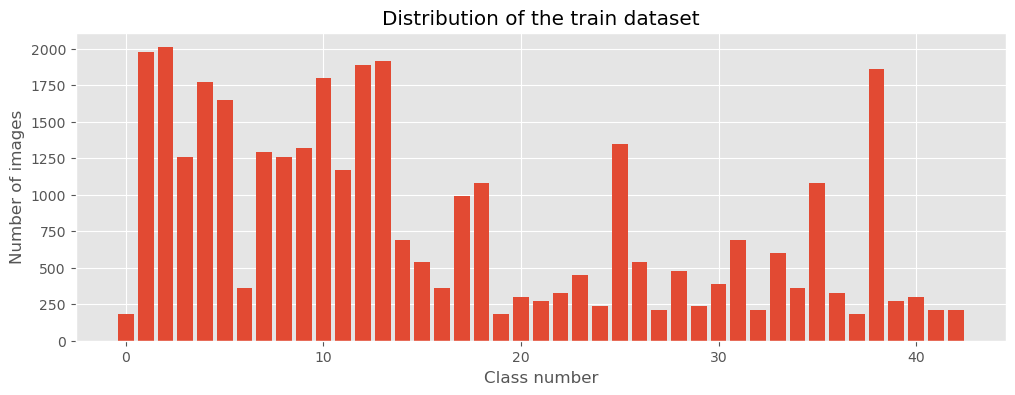

In [82]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

In [83]:
### Using OpenCV2 for preprocessing the image. 

(32, 32, 3)
36


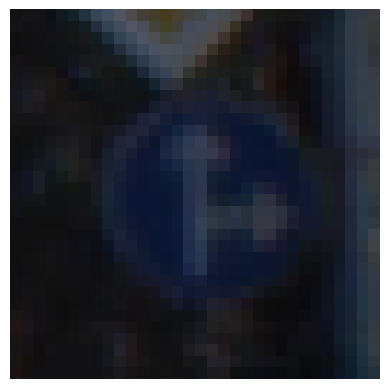

In [84]:

import cv2
 
plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

(32, 32)
(32, 32)


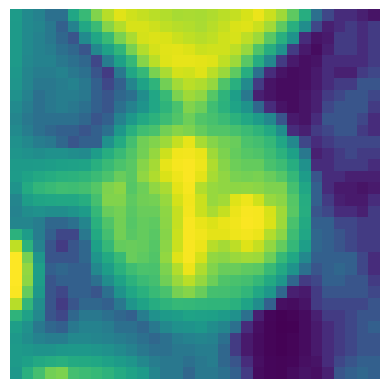

In [85]:
img = grayscale(X_train[1200])
plt.imshow(img)
plt.axis("off")
print(img.shape)
def equalize(img):
    img = cv2.equalizeHist(img)
    return img
img = equalize(img)
plt.imshow(img)
plt.axis("off")
print(img.shape)

In [86]:
def preprocess(img):
    img = grayscale(img)
    edges = cv2.Canny(img, 100, 200)
    img = equalize(img)
    img = img/255
    return img

(34799, 32, 32)


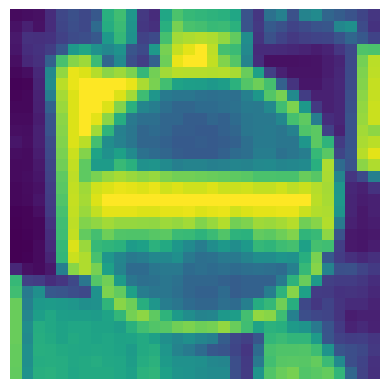

In [87]:
X_train = np.array(list(map(preprocess, X_train)))
X_test = np.array(list(map(preprocess, X_test)))
X_val = np.array(list(map(preprocess, X_val)))
 
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis('off')
print(X_train.shape)

In [88]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

### Applying the preprocessing function to every image in dataset

(15, 32, 32, 1)


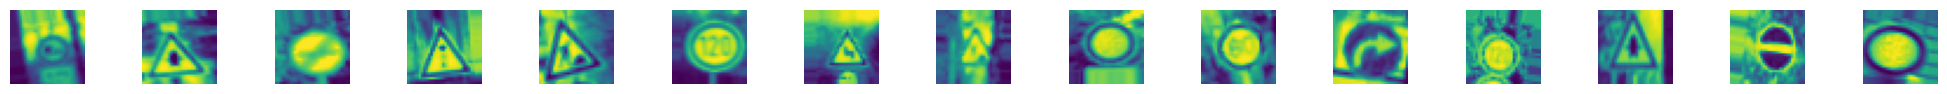

In [89]:
from keras.preprocessing.image import ImageDataGenerator
 
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.)
 
datagen.fit(X_train)
batches = datagen.flow(X_train, y_train, batch_size = 15)
X_batch, y_batch = next(batches)
 
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()
 
for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32))
    axs[i].axis("off")
 
print(X_batch.shape)

In [90]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

### Defining the CNN model. I have taken inspiration from the traditional LeNet architecture as I am curious how this old model performs on such a huge dataset.

In [91]:
 def modified_model():
  model = Sequential()
  model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(Conv2D(60, (5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(rate=0.25))
  
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(rate=0.25))
  
  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(43, activation='softmax'))
  
  model.compile(Adam(lr = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [92]:
model = modified_model()
print(model.summary())
 
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50),
                            epochs=20,
                            validation_data=(X_val, y_val), shuffle = 1)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 28, 28, 60)        1560      
                                                                 
 conv2d_13 (Conv2D)          (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 12, 12, 60)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 12, 12, 60)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 10, 10, 30)        16230     
                                                                 
 conv2d_15 (Conv2D)          (None, 8, 8, 30)          8130      
                                                      

C:\Users\91931\AppData\Local\Temp\ipykernel_12596\1181447703.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50),


696/696 [==============================] - 46s 65ms/step - loss: 2.0736 - accuracy: 0.4134 - val_loss: 0.4779 - val_accuracy: 0.8515
Epoch 2/20
696/696 [==============================] - 48s 69ms/step - loss: 0.8001 - accuracy: 0.7522 - val_loss: 0.1919 - val_accuracy: 0.9401
Epoch 3/20
696/696 [==============================] - 47s 67ms/step - loss: 0.5518 - accuracy: 0.8275 - val_loss: 0.1269 - val_accuracy: 0.9571
Epoch 4/20
696/696 [==============================] - 46s 66ms/step - loss: 0.4178 - accuracy: 0.8686 - val_loss: 0.0924 - val_accuracy: 0.9714
Epoch 5/20
696/696 [==============================] - 46s 66ms/step - loss: 0.3442 - accuracy: 0.8912 - val_loss: 0.0741 - val_accuracy: 0.9798
Epoch 6/20
696/696 [==============================] - 44s 63ms/step - loss: 0.2935 - accuracy: 0.9064 - val_loss: 0.0739 - val_accuracy: 0.9769
Epoch 7/20
696/696 [==============================] - 43s 62ms/step - loss: 0.2684 - accuracy: 0.9140 - val_loss: 0.0501 - val_accuracy: 0.9862
Epo

In [73]:
from sklearn.metrics import classification_report

# Evaluate the model on the validation dataset
y_val_pred = model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

# Convert one-hot encoded labels to categorical labels
y_val_categorical = np.argmax(y_val, axis=1)

# Print classification report
print("Classification Report:")
print(classification_report(y_val_categorical, y_val_pred_classes))


138/138 [==============================] - 2s 14ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       0.99      0.99      0.99       240
           2       0.99      0.99      0.99       240
           3       0.99      1.00      0.99       150
           4       0.98      1.00      0.99       210
           5       0.99      0.98      0.98       210
           6       1.00      1.00      1.00        60
           7       0.99      1.00      0.99       150
           8       0.99      0.97      0.98       150
           9       1.00      1.00      1.00       150
          10       1.00      1.00      1.00       210
          11       0.99      1.00      0.99       150
          12       1.00      1.00      1.00       210
          13       1.00      1.00      1.00       240
          14       1.00      1.00      1.00        90
          15       1.00      1.00      1.00        90
  

Text(0.5, 0, 'epoch')

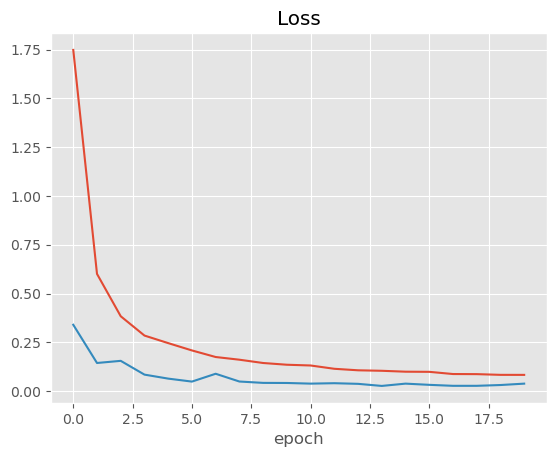

In [75]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')
 

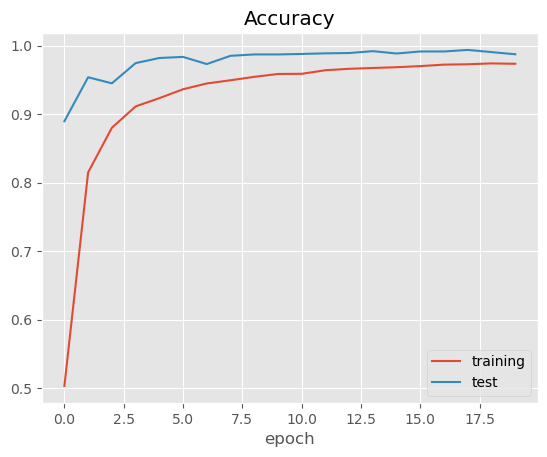

In [76]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','test'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.style.use('ggplot')